In [38]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# BigQuery Notebook Template: Sales Analysis

<table align="left">

  <td>
    <a href="https://xxx">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/colab-logo.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://xxx">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/github-logo.png" width="32" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://xxx">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
  <td>
    <a href="https://xxx">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>

</table>

| | |
|-|-|
|Author(s) | [Kasin Sumalyaporn](https://github.com/kasin-google) |

# An End-to-End E-commerce Sales Analysis and Forecasting with BigQuery


## Section 1: Getting Started with Your Data in BigQuery

Establish your digital workbench and understand your data. This section involves setting up cloud infrastructure, accessing the dataset, and exploring its structure.

### 1.1. Setting Up Your Google Cloud Environment

To begin, an analyst must have a Google Cloud project. The setup process is straightforward:

1.  **Create or Select a Project:** Sign in to the Google Cloud Console. For this analysis, it is recommended to create a new, dedicated project. This practice ensures that all resources are isolated and can be easily cleaned up or deleted upon completion without affecting other work.
2.  **Enable Billing (Optional but Recommended):** While BigQuery offers 1 TB free tier each month, which may already cover the analysis, enabling billing on the project is a prerequisite for moving beyond these limits.
3.  **Enable the BigQuery API:** For new projects, the BigQuery API is typically enabled by default. However, if working with a pre-existing project, it is essential to verify that the API is active to ensure all functionalities are available.


In [ ]:
PROJECT_ID = ""  # @param {type: "string"}
LOCATION = ""  # @param {type: "string"}


### 1.2. Accessing the `thelook_ecommerce` Dataset

1.  Navigate to the BigQuery page in the Google Cloud Console.
2.  In the **Explorer** pane, click the **+ADD** button.
3.  Select **Public datasets** from the menu. This will open the Google Cloud Marketplace in a new pane.
4.  In the search bar of the Marketplace, type `thelook_ecommerce`.
5.  Select the dataset from the search results and click **VIEW DATASET**.

This action will add the `bigquery-public-data` project to your Explorer pane, with the `thelook_ecommerce` dataset nested within it.




### 1.3. Initial Data Profiling and Schema Exploration

The `thelook_ecommerce` dataset contains several tables that capture different aspects of the business, including `users`, `products`, `orders`, `order_items`, and `events`. For our sales analysis, we will focus primarily on the tables that describe the customers, the products, and the transactions themselves.


Below is a summary of the key tables and columns that will form the basis of our sales analysis.

**Table 1: Schema Overview of Key `thelook_ecommerce` Tables**

| Table Name | Column Name | Data Type | Description |
| :--- | :--- | :--- | :--- |
| `users` | `id` | INTEGER | Unique identifier for each user. |
| | `age` | INTEGER | Age of the user. |
| | `gender` | STRING | Gender of the user ('M' or 'F'). |
| | `country` | STRING | Country where the user is located. |
| | `created_at` | TIMESTAMP | Timestamp when the user account was created. |
| `products` | `id` | INTEGER | Unique identifier for each product. |
| | `cost` | FLOAT | The cost of the product to the business. |
| | `retail_price` | FLOAT | The listed retail price of the product. |
| | `name` | STRING | Name of the product. |
| | `brand` | STRING | Brand of the product. |
| | `category` | STRING | Product category (e.g., 'Jeans', 'Sweaters'). |
| `orders` | `order_id` | INTEGER | Unique identifier for each order. |
| | `user_id` | INTEGER | Identifier for the user who placed the order. |
| | `status` | STRING | Status of the order (e.g., 'Complete', 'Shipped', 'Cancelled'). |
| | `created_at` | TIMESTAMP | Timestamp when the order was created. |
| | `num_of_item` | INTEGER | Number of unique items in the order. |
| `order_items`| `id` | INTEGER | Unique identifier for each line item in an order. |
| | `order_id` | INTEGER | Identifier for the associated order. |
| | `user_id` | INTEGER | Identifier for the user who placed the order. |
| | `product_id` | INTEGER | Identifier for the product purchased. |
| | `sale_price` | FLOAT | The actual price the item was sold for. |
| | `status` | STRING | Status of the order item (e.g., 'Complete', 'Returned'). |



-----



## Section 2: Starting Sales Analytics with SQL

This section employs descriptive and diagnostic analytics to create a comprehensive picture of the e-commerce store's performance. We will use Standard SQL in BigQuery to calculate key performance indicators (KPIs), analyze product and customer segments, and investigate the financial impact of returns and cancellations.


### 2.1. Analyzing Overall Sales Trends

The first step in any sales analysis is to understand the high-level trajectory of the business. Are sales growing? Is there a predictable seasonal pattern? How much is the average customer spending per transaction? To answer these questions, we will calculate monthly revenue, total orders, and Average Order Value (AOV).

The following SQL query uses Common Table Expressions (CTEs) to create a clean, readable structure. It first aggregates sales data from the order_items table to a monthly level and then calculates the key metrics.

In [ ]:
%%bigquery
-- Query to calculate monthly sales, orders, and average order value
WITH monthly_sales AS (
  SELECT
    -- Extract the year and month, and format as 'YYYY-MM' for clear labeling
    FORMAT_DATE('%Y-%m', created_at) AS sales_month,
    order_id,
    sale_price
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE
    -- Filter for completed orders to ensure we are analyzing actual sales
    status = 'Complete'
)
SELECT
  sales_month,
  -- Calculate total revenue by summing the sale prices
  SUM(sale_price) AS total_revenue,
  -- Count the number of distinct orders
  COUNT(DISTINCT order_id) AS total_orders,
  -- Calculate Average Order Value (AOV)
  SUM(sale_price) / COUNT(DISTINCT order_id) AS average_order_value
FROM
  monthly_sales
GROUP BY
  sales_month
ORDER BY
  sales_month;

Query is running:   0%|          |

Downloading:   0%|          |

,sales_month,total_revenue,total_orders,average_order_value
0,2019-01,127.510002,1,127.510002
1,2019-02,564.340009,10,56.434001
2,2019-03,1318.430004,19,69.391053
3,2019-04,2420.250001,21,115.250000
4,2019-05,1919.840005,21,91.420953
...,...,...,...,...
76,2025-05,102505.180044,1230,83.337545
77,2025-06,115359.440099,1356,85.073333
78,2025-07,138713.690233,1639,84.633124
79,2025-08,230950.790169,2737,84.380998


from matplotlib import pyplot as plt
_df_0['total_revenue'].plot(kind='hist', bins=20, title='total_revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['total_orders'].plot(kind='hist', bins=20, title='total_orders')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['average_order_value'].plot(kind='hist', bins=20, title='average_order_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='total_revenue', y='total_orders', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='total_orders', y='average_order_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['total_revenue'].plot(kind='line', figsize=(8, 4), title='total_revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['total_orders'].plot(kind='line', figsize=(8, 4), title='total_orders')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['average_order_value'].plot(kind='line', figsize=(8, 4), title='average_order_value')
plt.gca().spines[['top', 'right']].set_visible(False)

### 2.2. The Product Portfolio: Profitability, Performance, and Strategic Categorization
To understand true profitability, an e-commerce business must look beyond top-line revenue. A product with high revenue but also high costs may have low margins. By joining the `order_items` and `products` tables to access both `sale_price` and `cost`, you can uncover the "profitability illusion." A high-volume brand might be a low-margin workhorse, while a less prominent one could be a high-margin star. Focusing on gross profit (`sale_price` - `cost`) provides a more accurate view for strategic decisions, from marketing to inventory.

The following query calculates revenue and gross profit for each product category:



In [ ]:
%%bigquery sales_bcg_growth_share_matrix
-- Query to analyze Year-over-Year (YoY) sales growth by product category

-- CTE to aggregate total revenue by category and year
WITH yearly_sales_by_category AS (
  SELECT
    p.category,
    EXTRACT(YEAR FROM oi.created_at) AS sales_year,
    SUM(oi.sale_price) AS total_revenue,
    SUM(oi.sale_price - p.cost) AS total_gross_profit,
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items` AS oi
  JOIN
    `bigquery-public-data.thelook_ecommerce.products` AS p
    ON oi.product_id = p.id
  WHERE
    oi.status = 'Complete'
  GROUP BY
    p.category,
    sales_year
),

-- CTE to calculate the previous year's revenue for comparison
yoy_calculation AS (
  SELECT
    category,
    sales_year,
    total_revenue,
    total_gross_profit,
    -- Use the LAG window function to get the revenue from the prior year for each category
    LAG(total_revenue, 1, 0) OVER (PARTITION BY category ORDER BY sales_year) AS previous_year_revenue
  FROM
    yearly_sales_by_category
)

-- Final selection and calculation of YoY growth percentage
SELECT
  category,
  sales_year,
  total_revenue,
  previous_year_revenue,
  total_gross_profit,
  -- Calculate the YoY growth rate, handling cases where previous year's revenue is zero
  CASE
    WHEN previous_year_revenue = 0 THEN NULL -- Avoid division by zero; growth is undefined or infinite
    ELSE (total_revenue - previous_year_revenue) * 100.0 / previous_year_revenue
  END AS yoy_growth_percent
FROM
  yoy_calculation
WHERE
  sales_year = extract(year from current_date())
ORDER BY
  category,
  sales_year;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
sales_bcg_growth_share_matrix

,category,sales_year,total_revenue,previous_year_revenue,total_gross_profit,yoy_growth_percent
0,Accessories,2025,36991.799935,31150.159936,22213.830486,18.753162
1,Active,2025,40535.610009,29022.900034,23469.096955,39.667676
2,Blazers & Jackets,2025,23420.860073,17282.120092,14516.507401,35.520758
3,Clothing Sets,2025,1130.460001,1404.719999,426.510263,-19.524176
4,Dresses,2025,35591.340154,31179.340070,19664.603395,14.150396
5,Fashion Hoodies & Sweatshirts,2025,56028.700024,43384.230009,26821.020918,29.145314
6,Intimates,2025,41267.510026,28093.670032,19237.285598,46.892556
7,Jeans,2025,114164.410163,82562.330061,53170.700675,38.276633
8,Jumpsuits & Rompers,2025,3510.890017,1868.990013,1638.038800,87.849587
9,Leggings,2025,7898.419995,5044.089992,3158.392946,56.587611


This analysis can be elevated to a strategic level using the BCG Growth-Share Matrix. This framework classifies product categories into four quadrants based on their growth rate and profit contribution:

**Stars**: High growth, high profit. These are the future of the business and require investment.

**Cash Cows**: Low growth, high profit. These are mature, profitable categories that provide funds for other units.

**Question Marks**: High growth, low profit. These are speculative and require strategic nurturing to become Stars.

**Dogs**: Low growth, low profit. These categories may be candidates for divestment.

By plotting year-over-year sales growth against total profit for each category, you can provide leadership with a powerful visualization for portfolio management. For example, a "Star" would justify increased investment, while a "Dog" might be a candidate for discontinuation.







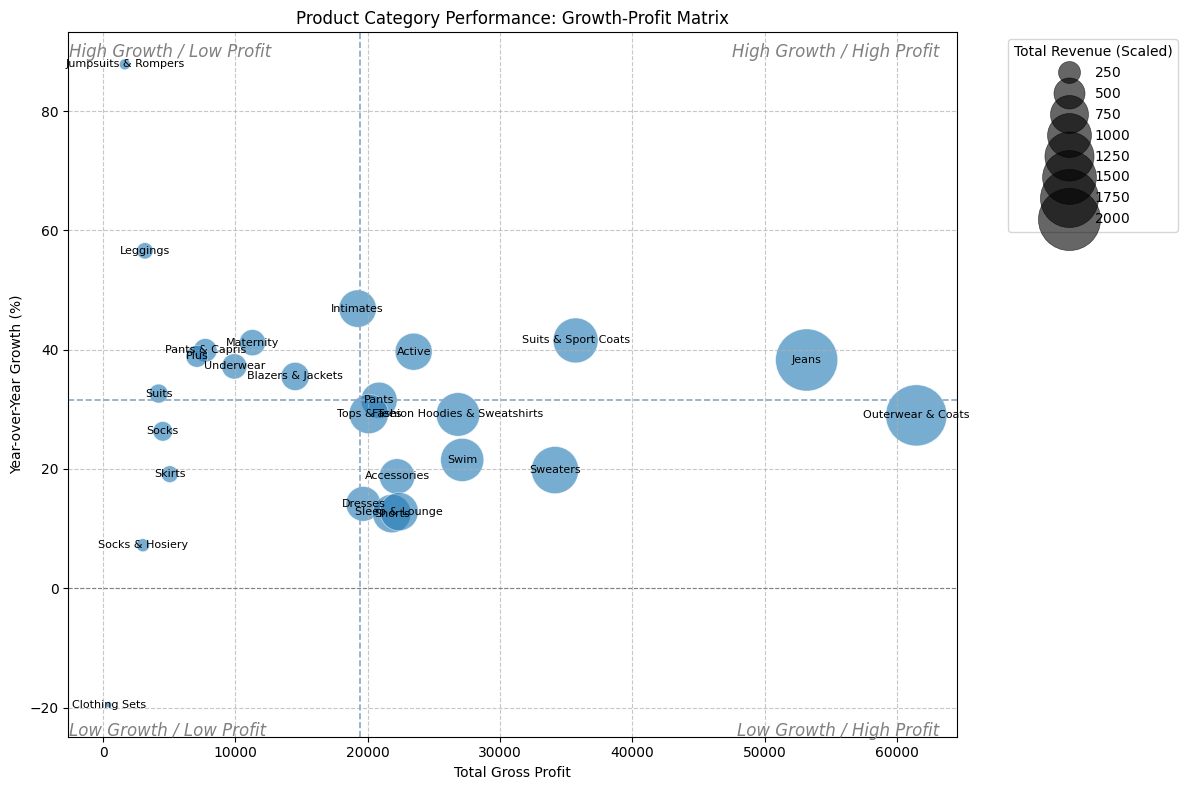

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the median values to serve as the quadrant dividers, ignoring negative values
x_median = sales_bcg_growth_share_matrix['total_gross_profit'][sales_bcg_growth_share_matrix['total_gross_profit'] >= 0].median()
y_median = sales_bcg_growth_share_matrix['yoy_growth_percent'][sales_bcg_growth_share_matrix['yoy_growth_percent'] >= 0].median()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=sales_bcg_growth_share_matrix['total_gross_profit'],
    y=sales_bcg_growth_share_matrix['yoy_growth_percent'],
    s=sales_bcg_growth_share_matrix['total_revenue'] / sales_bcg_growth_share_matrix['total_revenue'].max() * 2000, # Scale size for better visualization
    # color='#89A8C4',
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5
)

# --- Add Quadrant Lines and Labels ---
# Add vertical and horizontal lines at the median values
plt.axvline(x_median, color='#89A8C4', linestyle='--', linewidth=1.2)
plt.axhline(y_median, color='#89A8C4', linestyle='--', linewidth=1.2)

# Get axis limits for placing text
ax = plt.gca()
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Add quadrant labels
plt.text(xlims[1]*0.98, ylims[1]*0.98, 'High Growth / High Profit', ha='right', va='top', fontsize=12, color='gray', style='italic')
plt.text(xlims[0]*0.98, ylims[1]*0.98, 'High Growth / Low Profit', ha='left', va='top', fontsize=12, color='gray', style='italic')
plt.text(xlims[0]*0.98, ylims[0]*1.02, 'Low Growth / Low Profit', ha='left', va='bottom', fontsize=12, color='gray', style='italic')
plt.text(xlims[1]*0.98, ylims[0]*1.02, 'Low Growth / High Profit', ha='right', va='bottom', fontsize=12, color='gray', style='italic')

# Add labels for each bubble
for i, row in sales_bcg_growth_share_matrix.iterrows():
    plt.text(
        row['total_gross_profit'],
        row['yoy_growth_percent'],
        row['category'],
        fontsize=8,
        ha='center',
        va='center'
    )

plt.title('Product Category Performance: Growth-Profit Matrix')
plt.xlabel('Total Gross Profit')
plt.ylabel('Year-over-Year Growth (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a line at 0% growth

# Create a legend for bubble sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.legend(handles, labels, title="Total Revenue (Scaled)", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 2.3. The Customer Landscape: Geographic and Demographic Insights
Understanding who is buying is as crucial as understanding what they are buying. By joining sales and user data, you can build a customer profile valuable for targeted marketing and expansion.

For example, analysis of TheLook's customer data consistently shows a concentration in a few key regions, with China, the United States, and Brazil leading in both customer count and revenue. Further segmentation by gender and age can reveal additional insights. For instance, male customers might generate more revenue on average, or young adults and teenagers could be an underserved market.




The following query provides a breakdown of sales by country and gender:



In [ ]:
%%bigquery
-- Query to analyze sales by customer country and gender
SELECT
  u.country,
  u.gender,
  COUNT(DISTINCT o.user_id) AS total_customers,
  SUM(o.num_of_item) AS total_items_sold,
  SUM(oi.sale_price) AS total_revenue
FROM
  `bigquery-public-data.thelook_ecommerce.orders` AS o
JOIN
  `bigquery-public-data.thelook_ecommerce.users` AS u
  ON o.user_id = u.id
JOIN
  `bigquery-public-data.thelook_ecommerce.order_items` AS oi
  ON o.order_id = oi.order_id
WHERE
  o.status = 'Complete'
GROUP BY
  u.country,
  u.gender
ORDER BY
  total_revenue DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,country,gender,total_customers,total_items_sold,total_revenue
0,China,M,4513,14020,470430.130271
1,China,F,4724,14609,436935.170569
2,United States,M,3110,9615,318603.310288
3,United States,F,3142,9975,293552.350395
4,Brasil,M,2105,6486,215297.750150
5,Brasil,F,1927,6240,175802.880213
6,South Korea,F,743,2426,71300.290090
7,South Korea,M,728,2084,70694.690014
8,United Kingdom,M,644,2099,66602.390064
9,France,M,672,2126,65195.100010


### 2.4. The Other Side of the Coin: Analyzing Returns and Cancellations
Analysis of returns and cancellations is a critical, often-overlooked area of e-commerce. Returns represent not only lost revenue but also additional costs for logistics and operations. Analyzing which products are most frequently returned provides actionable feedback for quality control and product page optimization.


A striking pattern, known as the "popularity paradox," often emerges. The most popular and highest-selling product categories, like "Jeans" and "Fashion Hoodies & Sweatshirts," are frequently also the most returned. While more sales naturally lead to more returns, the key is to calculate the rate of return (`returned_items`/`total_items_sold`). If this rate is disproportionately high for popular items, it signals a systemic problem.

This could be caused by inconsistent sizing, inaccurate product photos, or a mismatch between perceived and actual quality. Addressing these issues for top-selling items can have a significant positive impact on overall profitability.



In [ ]:
%%bigquery products_returned
-- Query to calculate return rates by product category
WITH category_sales AS (
  SELECT
    p.category,
    COUNT(oi.id) AS total_items_sold,
    -- Count items with 'Returned' status
    COUNTIF(oi.status = 'Returned') AS returned_items
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items` AS oi
  JOIN
    `bigquery-public-data.thelook_ecommerce.products` AS p
    ON oi.product_id = p.id
  -- We consider all shipped orders, as an item must be shipped to be returned
  WHERE oi.status IN ('Shipped', 'Complete', 'Returned')
  AND EXTRACT(YEAR FROM oi.created_at) = EXTRACT(YEAR FROM current_date())
  GROUP BY
    p.category
)
SELECT
  category,
  total_items_sold,
  returned_items,
  -- Calculate the return rate as a percentage
  (returned_items / total_items_sold) * 100 AS return_rate_percent
FROM
  category_sales
WHERE
  total_items_sold > 100 -- Filter for categories with significant volume
ORDER BY
  return_rate_percent DESC;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
products_returned

,category,total_items_sold,returned_items,return_rate_percent
0,Suits,225,45,20.000000
1,Jumpsuits & Rompers,195,36,18.461538
2,Fashion Hoodies & Sweatshirts,2729,465,17.039209
3,Blazers & Jackets,725,116,16.000000
4,Pants,1644,263,15.997567
5,Maternity,1090,174,15.963303
6,Outerwear & Coats,1949,310,15.905593
7,Active,2124,337,15.866290
8,Sleep & Lounge,2420,383,15.826446
9,Jeans,2929,463,15.807443


## Section 3: Mapping the Customer Journey: Sales Funnel Analysis


### 3.1. Defining the Funnel Stages
The first step is to define a logical, linear sequence of events that represents the ideal customer path. Using the events table in the thelook_ecommerce dataset, which captures user actions with timestamps, we can construct a classic e-commerce funnel. A standard and effective funnel definition would be:

1. Page View: The user lands on any page of the website. This is the top of our funnel.

2. View Item: The user navigates to a specific product detail page. This indicates interest.

3. Add to Cart: The user clicks the "add to cart" button. This signals a strong intent to purchase.

4. Begin Checkout: The user proceeds from the cart to the checkout process.

5. Purchase: The user successfully completes the transaction.




** Based on the availability of data from this dataset, there are 4 stages defined: total sessions, added to cart, purchased, reviewed

### 3.2. Building the Funnel with SQL

In [ ]:
%%bigquery sales_funnel
WITH step1 AS (SELECT DISTINCT user_id, session_id FROM `bigquery-public-data.thelook_ecommerce.events` WHERE event_type = 'product'),
     step2 AS (SELECT DISTINCT user_id, session_id FROM `bigquery-public-data.thelook_ecommerce.events` WHERE event_type = 'cart'),
     step3 AS (SELECT DISTINCT user_id, session_id FROM `bigquery-public-data.thelook_ecommerce.events` WHERE event_type = 'purchase'),
     step4 AS (SELECT DISTINCT user_id, session_id FROM `bigquery-public-data.thelook_ecommerce.events` WHERE event_type = 'home')
SELECT
  (SELECT COUNT(*) FROM step1) AS total_sessions,
  COUNT(DISTINCT s2.session_id) AS added_to_cart,
  COUNT(DISTINCT s3.session_id) AS purchased,
  COUNT(DISTINCT s4.session_id) AS reviewed
FROM step1 s1
LEFT JOIN step2 s2 ON s1.session_id = s2.session_id
LEFT JOIN step3 s3 ON s2.session_id = s3.session_id
LEFT JOIN step4 s4 ON s3.session_id = s4.session_id;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
sales_funnel

,total_sessions,added_to_cart,purchased,reviewed
0,681272,430966,181272,87080


In [ ]:
import plotly.graph_objects as go

# Assuming sales_funnel is a pandas DataFrame with a single row
total_sessions = sales_funnel['total_sessions'].iloc[0]
added_to_cart = sales_funnel['added_to_cart'].iloc[0]
purchased = sales_funnel['purchased'].iloc[0]
reviewed = sales_funnel['reviewed'].iloc[0]

# Define the stages and their values
stages = ["Total Sessions", "Added to Cart", "Purchased", "Reviewed"]
values = [total_sessions, added_to_cart, purchased, reviewed]

# Calculate drop-off rates
drop_off_rates = []
for i in range(len(values) - 1):
    drop_off = values[i] - values[i+1]
    drop_off_rate = (drop_off / values[i]) * 100 if values[i] > 0 else 0
    drop_off_rates.append(f"{drop_off_rate:.2f}% drop-off")

# Create the funnel chart
fig = go.Figure(go.Funnel(
    y=stages,
    x=values,
    textinfo="value+percent initial",
    marker={"color": ["#636EFA", "#EF553B", "#00CC96", "#AB63FA"]},
    connector={"line": {"color": "grey", "dash": "dot", "width": 2}}
))

# Add annotations for drop-off rates
for i, rate_text in enumerate(drop_off_rates):
    fig.add_annotation(
        x=values[i+1] + (values[i] - values[i+1]) / 2,  # Midpoint between stages
        y=stages[i+1],
        text=rate_text,
        showarrow=False,
        font=dict(size=10, color="red"),
        xshift=50,
        yshift=0
    )

fig.update_layout(
    title_text="Sales Funnel Analysis with Drop-off Rates",
    title_x=0.5,
    height=500,
    width=800
)

fig.show()

The results of this analysis can be very revealing. While some user drop-off is normal, a disproportionately large drop-off pinpoints a major point of friction.

In many e-commerce funnels, the most significant leak occurs between the "Add to Cart" and "Purchase" stages. When a user abandons the process at this point, it's rarely due to a lack of interest in the product. Instead, it signals a failure in the checkout process itself.

Potential culprits include:

* Mandatory account creation

* Unexpectedly high shipping costs

* Confusing or lengthy forms

* A lack of trusted payment options



Pinpointing this specific drop-off gives the UX and web development teams a high-priority, high-impact area to focus on. Fixing this leak—through methods like A/B testing, guest checkout options, or transparent shipping costs—can yield a greater return on investment than a new marketing campaign, as it focuses on converting users who are already at the brink of buying.








## Section 4: Predicting the Future: A Practical Guide to Sales Forecasting
The analyses so far have been retrospective, but a strategic analyst must also look forward. **Sales forecasting** moves the analytics function from a reactive reporting role to a proactive, advisory one. By using historical data to predict future outcomes, an analyst can provide invaluable intelligence for inventory management, marketing, and financial budgeting.


### 4.1. Understanding Time-Series Data
Our monthly sales data, calculated in Section 2.1, is a classic example of time-series data: a sequence of data points indexed in chronological order. To forecast it effectively, we must first understand its constituent components:

Trend: The long-term upward or downward movement in the data. Is the business fundamentally growing, shrinking, or stable over time?

Seasonality: Predictable, repeating patterns or fluctuations that occur at fixed intervals, such as weekly, monthly, or yearly cycles. For retail, this often manifests as a large spike in sales during the Q4 holiday season.

Irregularity (or Noise): Random, unpredictable variations in the data that are not explained by trend or seasonality.



### 4.2. Choosing the Right Model: BigQuery's Zero-Shot Forecasting with TimesFM
While numerous statistical models like ARIMA exist for time-series forecasting, recent advancements in large-scale AI have introduced a new class of powerful tools known as foundation models. BigQuery now integrates TimesFM, a state-of-the-art, pre-trained time-series foundation model from Google Research, making advanced forecasting accessible directly within the data warehouse.

For quick, high-quality baseline forecasts with minimal setup, TimesFM is the ideal choice. For scenarios that require deep customization, the inclusion of external variables (like marketing spend), or a high degree of model explainability, BigQuery's ARIMA_PLUS model remains a powerful alternative.



### 4.3. Step-by-Step Forecasting with `AI.FORECAST`
The entire forecasting process can be executed within a single BigQuery SQL query, eliminating the need to export data or manage external environments.

Data Preparation: The foundation for our forecast is the same monthly sales data aggregated in Section 2.1. The `AI.FORECAST` function requires a table with, at minimum, a timestamp column and a numeric value column to be forecasted.

Generating the Forecast: We use the `AI.FORECAST` function, passing our prepared data as input and specifying our desired forecast horizon.



In [ ]:
%%bigquery

  SELECT *
  FROM
    AI.FORECAST(
      (
        SELECT
          TIMESTAMP_TRUNC(created_at, DAY) as order_date,
          sum(sale_price) as total_sales
        FROM
         `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
          -- Filter for completed orders to ensure we are analyzing actual sales
          status = 'Complete'
        GROUP BY
          order_date
      ),
      horizon => 90,
      confidence_level => 0.95,
      timestamp_col => 'order_date',
      data_col => 'total_sales');



Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery actual_vs_forecast_sales

WITH historical AS (
  SELECT
    TIMESTAMP_TRUNC(created_at, DAY) as order_date,
    sum(sale_price) as total_sales
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE
    -- Filter for completed orders to ensure we are analyzing actual sales
    status = 'Complete'
    AND created_at >= TIMESTAMP('2025-01-01')
  GROUP BY
    order_date
)
SELECT *
FROM
(
(SELECT
    order_date as date,
    total_sales AS historical_value,
    NULL as forecast_value,
    'historical' as type,
    NULL as prediction_interval_lower_bound,
    NULL as prediction_interval_upper_bound
FROM
    historical
ORDER BY historical.order_date DESC
LIMIT 400)
UNION ALL
(SELECT forecast_timestamp AS date,
        NULL as historical_value,
        forecast_value as forecast_value,
        'forecast' as type,
        prediction_interval_lower_bound,
        prediction_interval_upper_bound
FROM
    AI.FORECAST(
    (
    SELECT * FROM historical
    ),
    horizon => 90,
    confidence_level => 0.99,
    timestamp_col => 'order_date',
    data_col => 'total_sales')))
ORDER BY date asc;

Query is running:   0%|          |

Downloading:   0%|          |

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' column is in datetime format
actual_vs_forecast_sales['date'] = pd.to_datetime(actual_vs_forecast_sales['date'])

plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(actual_vs_forecast_sales[actual_vs_forecast_sales['type'] == 'historical']['date'],
         actual_vs_forecast_sales[actual_vs_forecast_sales['type'] == 'historical']['historical_value'],
         label='Historical Sales', color='blue')

# Plot forecast data
plt.plot(actual_vs_forecast_sales[actual_vs_forecast_sales['type'] == 'forecast']['date'],
         actual_vs_forecast_sales[actual_vs_forecast_sales['type'] == 'forecast']['forecast_value'],
         label='Forecasted Sales', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(actual_vs_forecast_sales[actual_vs_forecast_sales['type'] == 'forecast']['date'],
                 actual_vs_forecast_sales[actual_vs_forecast_sales['type'] == 'forecast']['prediction_interval_low'],
                 actual_vs_forecast_sales[actual_vs_forecast_sales['type'] == 'forecast']['prediction_interval_upper_bound'],
                 color='red', alpha=0.2, label='99% Confidence Interval')

plt.title('Historical vs. Forecasted Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'actual_vs_forecast_sales' is not defined

## Section 5 Summary

An analysis, no matter how sophisticated, is incomplete until its findings are translated into an actionable business strategy. This final section synthesizes key discoveries from our investigation into a cohesive narrative. It provides concrete, data-driven recommendations for departments and outlines a blueprint for institutionalizing this analysis through a performance dashboard.

This section uses Gemini as an example of how findings and recommendations can be preprepared. The example passes the result from BCG matrix and the product return rate in Section 2 to the model.

In [41]:
import pandas as pd
import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig

# --- 1. Configuration and Authentication ---

# Initialize the Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=LOCATION)

# --- 2. Engineer the Prompt for Gemini ---

# Convert DataFrames to markdown format for the model to easily parse
bcg_matrix_md = sales_bcg_growth_share_matrix.to_markdown(index=False)
returns_md = products_returned.to_markdown(index=False)

# Create a detailed prompt that provides context, data, and instructions
prompt = f"""
You are an expert e-commerce data analyst and business strategist for an online fashion retailer.
Your task is to analyze two datasets to identify key insights and provide actionable recommendations to improve profitability and reduce customer returns.

Here are the two datasets in markdown format:

**Dataset 1: BCG Growth-Share Matrix**
This table categorizes our product lines based on their market growth and relative market share, proxied by gross profit.
- **Stars:** High growth, high share. Require investment.
- **Cash Cows:** Low growth, high share. Generate stable profit.
- **Question Marks:** High growth, low share. Uncertain potential.
- **Dogs:** Low growth, low share. May be candidates for divestment.

{bcg_matrix_md}


**Dataset 2: Top Product Categories by Return Rate**
This table shows the product categories with the highest return rates.

{returns_md}


**Analysis Task:**
Cross-reference these two datasets to uncover critical insights. Pay close attention to the relationship between a category's BCG quadrant and its return rate. Based on your analysis, provide a set of strategic recommendations.

**Required Output Format:**

**1. Key Insights:**
*   (Insight 1: A critical observation derived from combining both datasets. For example, identify if a 'Cash Cow' is suffering from high returns.)
*   (Insight 2: Another observation. For example, identify if a promising 'Question Mark' has a healthy low return rate.)
*   (Insight 3: A third observation.)

**2. Strategic Recommendations:**
*   **For the Merchandising/Product Team:**
    *   **Recommendation:** (Specific, actionable advice, e.g., "Investigate sizing inconsistencies for the Jeans category.")
    *   **Problem Addressed:** (The insight this recommendation is based on.)
    *   **Expected Outcome:** (The desired business impact, e.g., "Reduce return rate for Jeans by 2% and improve gross profit margin.")
*   **For the Marketing Team:**
    *   **Recommendation:** (Specific, actionable advice, e.g., "Increase marketing spend on the 'Sleep & Lounge' category.")
    *   **Problem Addressed:** (The insight this recommendation is based on.)
    *   **Expected Outcome:** (The desired business impact, e.g., "Accelerate growth to transition 'Sleep & Lounge' from a 'Question Mark' to a 'Star'.")
*   **For the Operations Team:**
    *   **Recommendation:** (Specific, actionable advice, e.g., "Evaluate the potential of discontinuing the 'Socks & Hosiery' line.")
    *   **Problem Addressed:** (The insight this recommendation is based on.)
    *   **Expected Outcome:** (The desired business impact, e.g., "Free up inventory capital and reduce operational overhead from a low-performing category.")
"""

# --- 3. Call the Vertex AI Gemini API ---

# Instantiate the Gemini 2.5 Flash model
model = GenerativeModel("gemini-2.5-flash")

# Configure generation parameters for a more deterministic, analytical response
generation_config = GenerationConfig(
    temperature=0.2,
    top_p=0.8,
    top_k=40,
    max_output_tokens=10240,
)

print("--- Sending request to Gemini for analysis... ---")

# Send the prompt to the model
response = model.generate_content(
    prompt,
    generation_config=generation_config
)

print("--- Analysis Complete. Results: ---")

# --- 4. Display the Results ---
print(response.text)

--- Sending request to Gemini for analysis... ---
--- Analysis Complete. Results: ---
As an expert e-commerce data analyst and business strategist, I have cross-referenced your BCG Growth-Share Matrix data with your product return rate data. This analysis reveals critical insights into your product portfolio's health and provides actionable strategies to enhance profitability and reduce returns.

---

**1. Key Insights:**

*   **Insight 1: Profit Erosion in Core Categories:** Several high-value "Cash Cow" categories (e.g., Fashion Hoodies & Sweatshirts, Outerwear & Coats, Sweaters) and "Star" categories (e.g., Jeans, Pants, Active) exhibit elevated return rates (ranging from 15% to 17%). These categories are critical for current profitability and future growth, and high returns directly erode their contribution margins, turning potential high-profit items into operational burdens.
*   **Insight 2: High Risk for Emerging Potential:** "Question Mark" categories like "Suits" (20% return r

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.